# Test Region
Avoid making long computations again and again with this notebook!

## Structural Similarity Matrix

### Data Loading

In [6]:
from librosa.util.utils import frame
import numpy as np
import scipy
import sklearn

from madmom.features.beats import RNNBeatProcessor
from madmom.features.beats import DBNBeatTrackingProcessor
from madmom.features.key import CNNKeyRecognitionProcessor
from madmom.features.key import key_prediction_to_label

import librosa

from essentia.standard import FrameGenerator, PeakDetection

from data_loading import *
from feature_extraction import *
from track_selection import *
import utils

In [2]:
load_path = "../songs/test"
playlist = load_data(load_path)
song = playlist[0]

In [3]:
print(len(playlist))

6


## Feature Extraction

Extracting features
	Song 1 / 6
		Estimating beat...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating key...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating cue-points
	Song 2 / 6
		Estimating beat...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating key...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating cue-points
	Song 3 / 6
		Estimating beat...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating key...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating cue-points
	Song 4 / 6
		Estimating beat...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating key...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating cue-points
	Song 5 / 6
		Estimating beat...
		Estimating key...
		Estimating cue-points


/mnt/c/Users/javig/Documents/GitHub/song_mixing/code/utils.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


	Song 6 / 6
		Estimating beat...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating key...


/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


		Estimating cue-points


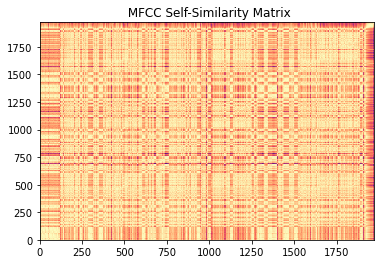

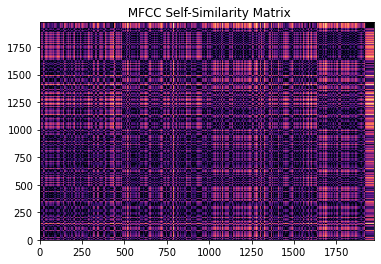

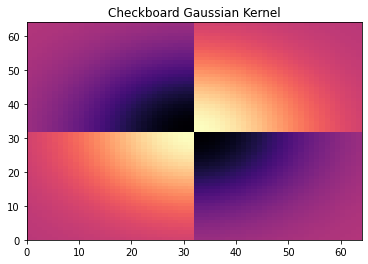

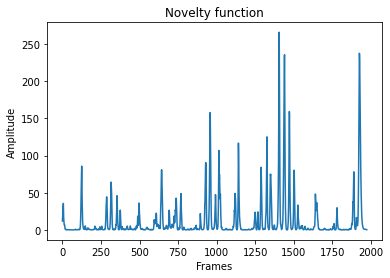

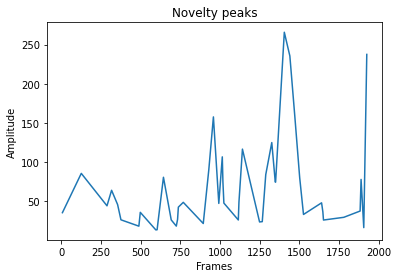

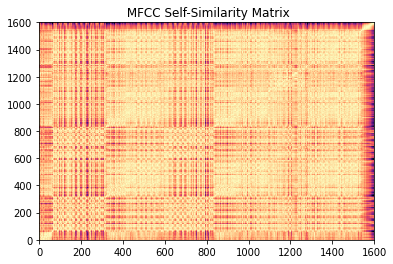

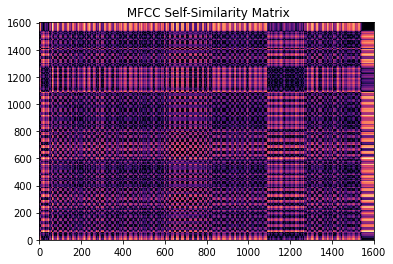

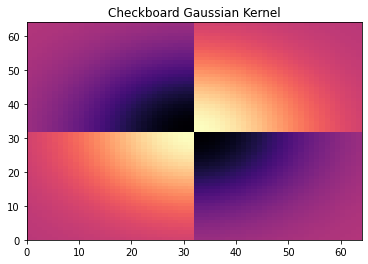

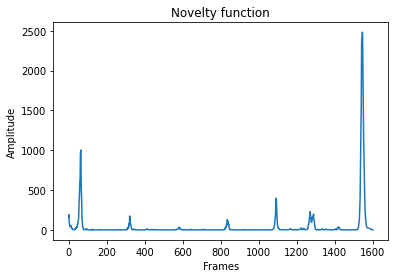

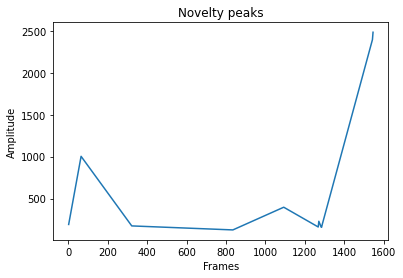

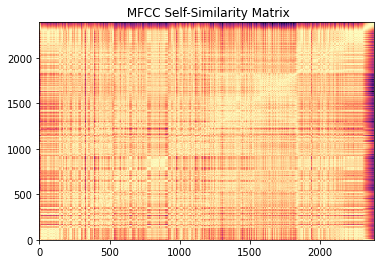

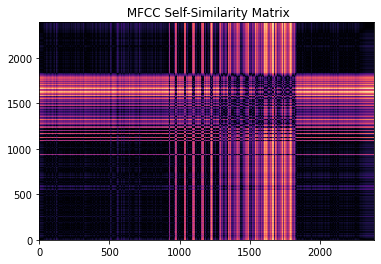

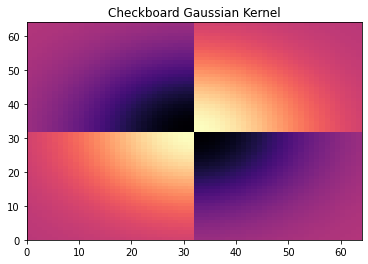

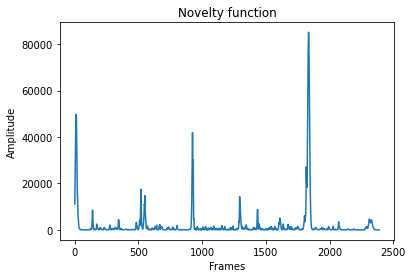

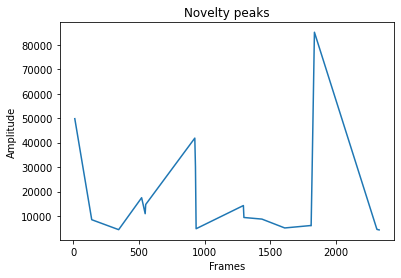

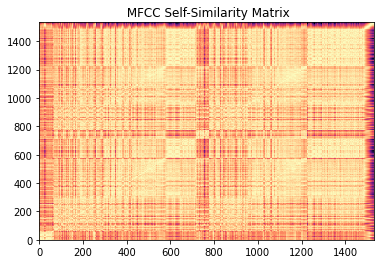

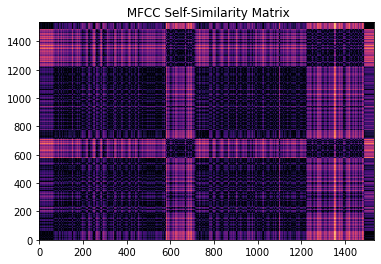

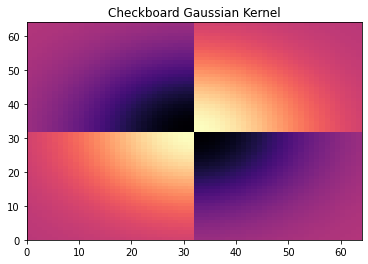

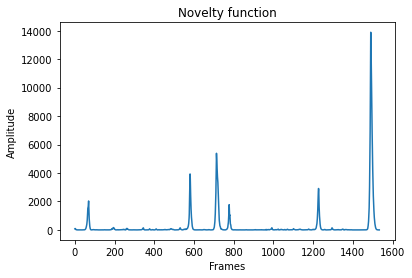

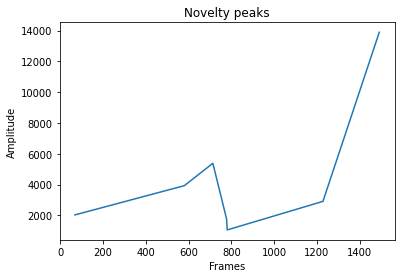

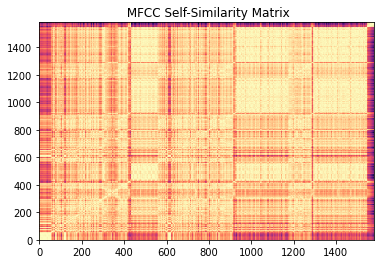

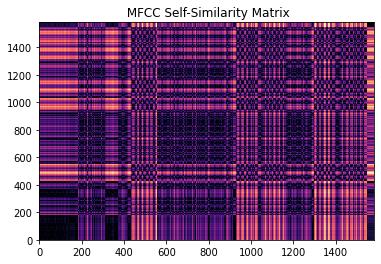

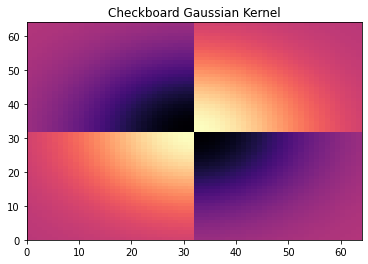

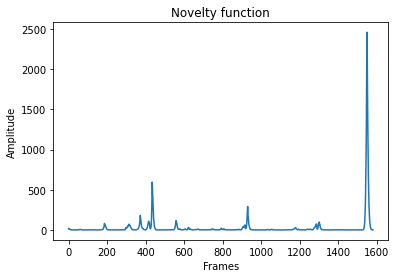

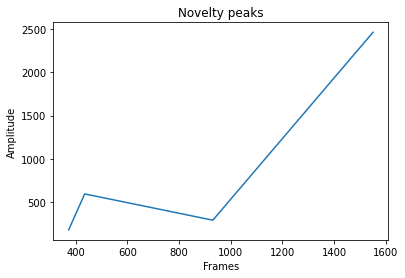

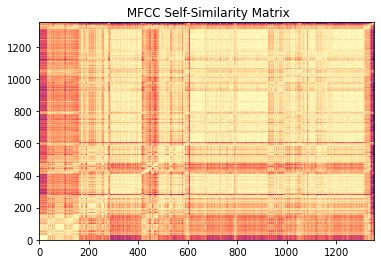

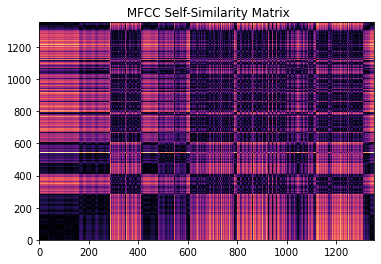

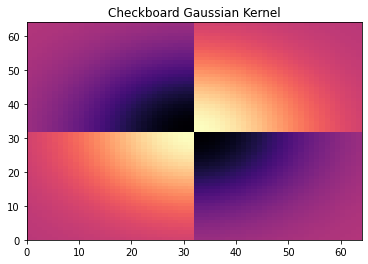

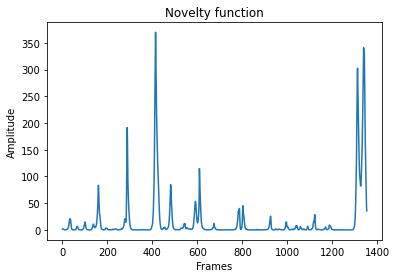

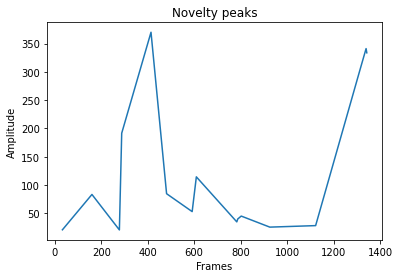

In [4]:
playlist = feature_extraction(playlist)

In [12]:
from track_selection import get_song_sequence

In [20]:
queue = get_song_sequence(playlist)

In [47]:
def select_cue_points(previous_mix):

    cue_point = np.zeros_like(previous_mix['cue_points'])

    possible_idx = np.where(previous_mix['cue_points'] == 1)[0]
    
    cue_point_idx = possible_idx[possible_idx > previous_mix['cue_points'].size - 10*previous_mix['frame_rate']][0]    

    cue_point[cue_point_idx] = 1

    return cue_point

In [48]:
previous_mix = queue[0]
next_song = queue[1]

In [49]:
previous_mix_cue_point = select_cue_points(previous_mix)

In [50]:
avg_bpm = (previous_mix['estimated_bpm'] + next_song['estimated_bpm']) / 2

cue_point_idx = np.where(previous_mix_cue_point == 1)[0][0]

ending_length_samples = previous_mix['audio_array'].size - cue_point_idx
ending_length_seconds = ending_length_samples / previous_mix['frame_rate']
beginning_length_samples = int(ending_length_seconds * next_song['frame_rate'])

In [51]:
ending_audio = previous_mix['audio_array'][-ending_length_samples:]
ending_beats = previous_mix['beat_times'][-ending_length_samples:]
ending_cue_points = previous_mix['cue_points'][-ending_length_samples:]
ending_previous_cue_point = previous_mix_cue_point[-ending_length_samples:]

beginning_audio = next_song['audio_array'][:beginning_length_samples]
beginning_beats = next_song['beat_times'][:beginning_length_samples]
beginning_cue_points = next_song['cue_points'][:beginning_length_samples]

In [61]:
import pyrubberband as pyrb

In [62]:
ending_stretching_ratio = avg_bpm/previous_mix['estimated_bpm']
ending_audio_stretched = pyrb.time_stretch(ending_audio, previous_mix['frame_rate'], ending_stretching_ratio)
ending_beats_stretched = pyrb.time_stretch(ending_beats, previous_mix['frame_rate'], ending_stretching_ratio)
ending_cue_points_stretched = pyrb.time_stretch(ending_cue_points, previous_mix['frame_rate'], ending_stretching_ratio)
ending_previous_cue_point_stretched = pyrb.time_stretch(ending_previous_cue_point, previous_mix['frame_rate'], ending_stretching_ratio)

In [63]:
beginning_stretching_ratio = avg_bpm/next_song['estimated_bpm']
beginning_audio_stretched = pyrb.time_stretch(beginning_audio, next_song['frame_rate'], beginning_stretching_ratio)
beginning_beats_stretched = pyrb.time_stretch(beginning_beats, next_song['frame_rate'], beginning_stretching_ratio)
beginning_cue_points_stretched = pyrb.time_stretch(beginning_cue_points, next_song['frame_rate'], beginning_stretching_ratio)

In [64]:
new_previous = previous_mix.copy()
new_previous['audio_array'] = np.concatenate((new_previous['audio_array'][:-ending_length_samples], ending_audio_stretched))
new_previous['beat_times'] = np.concatenate((new_previous['audio_array'][:-ending_length_samples], ending_beats_stretched))
new_previous['cue_points'] = np.concatenate((new_previous['cue_points'][:-ending_length_samples], ending_cue_points_stretched))

In [65]:
new_next = next_song.copy()
new_next['audio_array'] = np.concatenate((new_next['audio_array'][:-ending_length_samples], beginning_audio_stretched))
new_next['beat_times'] = np.concatenate((new_next['audio_array'][:-ending_length_samples], beginning_beats_stretched))
new_next['cue_points'] = np.concatenate((new_next['audio_array'][:-ending_length_samples], beginning_cue_points_stretched))

In [70]:
ending_audio_stretched.size

269025

In [66]:
import IPython.display as ipd

In [76]:
ipd.Audio(beginning_audio_stretched, rate=next_song['frame_rate'])

### Functions

In [19]:
circle_of_fifths = {
    'major' : ['C','G','D','A' ,'E' ,'B' ,'F#','C#','G#','D#','A#', 'F'],
    'minor' : ['A','E','B','F#','C#','G#','D#','A#','F' ,'C' ,'G' ,'D']
}
scale = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

def get_song_sequence(playlist):

    not_in_queue = playlist.copy()

    not_in_queue.sort(key=lambda song: song['estimated_bpm'])

    queue = []
    
    queue.append(not_in_queue.pop(0))

    while not_in_queue:

        next_song = pick_next_song(queue[-1], not_in_queue)
        queue.append(next_song)
        not_in_queue.remove(next_song) 

    return queue


def pick_next_song(current, options):
    '''
        Explore several strategies

        Example:
            - Selecting candidate inside a +- bpm bounds
            - Picking the most similar one in key
            (see the paper for inspiration in distances between keys)
    '''
    
    threshold = 10

    selection = None
    #lower_bound, upper_bound = bpm_bounds(current["bpm"],thresh)
    current_bpm = current['estimated_bpm']
    current_key_distance = 12 # Maximum distance
    

    while not selection:

        for song in options:
            
            if song['estimated_bpm'] >= current_bpm - threshold and song['estimated_bpm'] <= current_bpm + threshold:
                
                optional_key_distance = key_distance_fifths(current['estimated_key'], current['mode'], song['estimated_key'], song['mode'])
                
                if optional_key_distance < current_key_distance:
                    
                    selection = song
                    current_key_distance = optional_key_distance
        
        threshold += 5
        

    return selection

# Do we need that?
def bpm_bounds(bpm,thresh):
    
    return bpm-thresh, bpm+thresh

def key_distance_semitones(key1, key2):

    idx1 = scale.index(key1)
    idx2 = scale.index(key2)

    diff = abs(idx1 - idx2)

    distance = min(diff, 12-diff)
    
    return distance

def key_distance_fifths(key1, mode1, key2, mode2):

    idx1 = circle_of_fifths[mode1].index(key1)
    idx2 = circle_of_fifths[mode2].index(key2)

    diff = abs(idx1 - idx2)

    distance = min(diff, 12-diff)
    
    return distance

In [ ]:
def beat_detection(song):
    
    proc = DBNBeatTrackingProcessor(fps=100)
    act = RNNBeatProcessor()(song["song_path"])
    beat_times = proc(act)

    # create the array of ones and zeros
    beat_frames = convert_to_frames(beat_times,song)

    # compute the bpm of the song
    bpm = beats_per_minute(beat_times,song)

    return beat_frames, bpm

def convert_to_frames(beat_times, song):

    beat_frames = (beat_times*song["frame_rate"]).astype(int)
    beat_frames_mapped = np.zeros_like(song["audio_array"])
    beat_frames_mapped[beat_frames] = 1
    
    return beat_frames_mapped

def beats_per_minute(beat_times, song):
    
    song_length = len(song["audio_array"])/song["frame_rate"]/60
    beats_count = len(beat_times)
    
    bpm = beats_count/song_length # We could have problems with the first and the last beat
    
    return bpm

def key_detection(song):

    #key = rubberband/madmom (experiment with both)
    
    proc = CNNKeyRecognitionProcessor()
    key_probabilities = proc(song["song_path"])
    key_label = key_prediction_to_label(key_probabilities)

    return key_probabilities, key_label

In [ ]:

def mfcc_structural_similarity_matrix(song, frame_size, hop_size):

    mspec = librosa.feature.melspectrogram(song['audio_array'], sr=song['frame_rate'], n_mels=128, n_fft=frame_size, window="hann", win_length=frame_size, hop_length=hop_size,)

    log_mspec = librosa.power_to_db(mspec, ref=np.max)

    mfcc = librosa.feature.mfcc(S = log_mspec, sr=song['frame_rate'], n_mfcc=13)

    ssm = sklearn.metrics.pairwise.cosine_similarity(mfcc.T, mfcc.T)
    
    ssm -= np.average(ssm)
    m = np.min(ssm)
    M = np.max(ssm)
    ssm -= m
    ssm /= np.abs(m) + M

    return ssm


def rms_structural_similarity_matrix(song, frame_size, hop_size):

    rms_list = []
    for frame in FrameGenerator(song['audio_array'], frameSize = frame_size, hopSize = hop_size):
        rms_list.append(np.average(frame**2))

    ssm = sklearn.metrics.pairwise.pairwise_distances(np.array(rms_list).reshape(-1, 1))

    ssm -= np.average(ssm)
    m = np.min(ssm)
    M = np.max(ssm)
    ssm -= m
    ssm /= np.abs(m) + M

    return ssm


def get_checkboard_kernel(dim):

    gaussian_x = scipy.signal.gaussian(2*dim, std = dim/2.0).reshape((-1,1))
    gaussian_y = scipy.signal.gaussian(2*dim, std = dim/2.0).reshape((1,-1))

    kernel = np.dot(gaussian_x,gaussian_y)

    kernel[:dim,dim:] *= -1
    kernel[dim:,:dim] *= -1

    return kernel
    

def apply_kernel(ssm, kernel):

    kernel_dim = int(kernel.shape[0]/2)
    ssm_dim = ssm.shape[0]

    novelty = np.zeros(ssm_dim)

    ssm_padded = np.pad(ssm, kernel_dim, mode='edge')

    for index in range(ssm_dim):
        frame = ssm_padded[index:index+2*kernel_dim, index:index+2*kernel_dim]
        novelty[index] = np.sum(frame * kernel)
    
    novelty /= np.max(novelty)
    
    return novelty


def detect_peaks(novelty):

    threshold = np.max(novelty) * 0.05
    
    peakDetection = PeakDetection(interpolate=False, maxPeaks=100, orderBy='amplitude', range=len(novelty), maxPosition=len(novelty), threshold=threshold)
    peaks_pos, peaks_ampl = peakDetection(novelty.astype('single'))
    peaks_ampl = peaks_ampl[np.argsort(peaks_pos)]
    peaks_pos = peaks_pos[np.argsort(peaks_pos)]

    return peaks_pos, peaks_ampl


def find_near_beat(position, beat_times):

    position = int(position)

    i_low = 0
    i_up = 0
    while(position - i_low > 0 and beat_times[position-i_low] == 0):
        i_low += 1
    while(position + i_up < len(beat_times) and beat_times[position+i_up] == 0):
        i_up += 1

    if i_low < i_up:
        return position - i_low
    else:
        return position + i_up


### Beat detection

In [ ]:
beats_frames, bpm = beat_detection(song) 
song['beat_times'] = beats_frames # Array like the samples marking with the beat ocurrs, ones/zeros
song['estimated_bpm'] = bpm # Int

### Key detection

In [ ]:
key_probabilities, key_label = key_detection(song)
song['estimated_key'] = key_label.split(' ')[0] # Probalby string or a int encoding of all the keys
song['estimated_mode'] = key_label.split(' ')[1]
song['key_probabilities'] = key_probabilities

### Structural sementation

In [ ]:
kernel_dim = 32

samples_per_beat = int(1.0/(song['estimated_bpm']/(60.0 * song['frame_rate'])))

frame_size = int(0.5 * samples_per_beat)
hop_size = int(0.25 * samples_per_beat)

In [ ]:
mfcc_ssm = mfcc_structural_similarity_matrix(song, frame_size=frame_size, hop_size=hop_size)
rms_ssm = rms_structural_similarity_matrix(song, frame_size=frame_size, hop_size=hop_size)

In [ ]:
kernel = get_checkboard_kernel(kernel_dim)
mfcc_novelty = apply_kernel(mfcc_ssm, kernel)
rms_novelty = apply_kernel(rms_ssm, kernel)

In [ ]:
size_dif = mfcc_novelty.size - rms_novelty.size
if size_dif > 0:
    rms_novelty = np.pad(rms_novelty, (0, np.abs(size_dif)), mode='edge')
else:
    mfcc_novelty = np.pad(mfcc_novelty, (0, np.abs(size_dif)), mode='edge')

novelty = mfcc_novelty * rms_novelty

In [ ]:
peaks_rel_pos, peaks_amp = detect_peaks(novelty)

peaks_abs_pos = peaks_rel_pos * hop_size

peak_times = np.zeros_like(song['audio_array'])

for i in range(len(peaks_abs_pos)):
    beat_peak = find_near_beat(peaks_abs_pos[i], song['beat_times'])
    peak_times[beat_peak] = 1

In [ ]:
print(np.where(peak_times==1))

In [ ]:
utils.save_cmap(mfcc_ssm, '../figures/mfcc_smm.png', ' MFCC Self-Similarity Matrix')
utils.save_cmap(rms_ssm, '../figures/rms_smm.png', ' MFCC Self-Similarity Matrix')
utils.save_cmap(kernel, '../figures/kernel', 'Checkboard Gaussian Kernel')
utils.save_line(range(len(novelty)), novelty, '../figures/novelty.png', 'Novelty function', 'Frames', 'Amplitude')
utils.save_line(peaks_rel_pos, peaks_amp, '../figures/peaks.png', 'Novelty peaks', 'Frames', 'Amplitude', '.')

## Testing

In [ ]:
song['estimated_key']